In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

In [5]:
from pathlib import Path
from fastai.basic_train import load_learner

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [8]:
content_img = image_loader("/home/jupyter/data/" + "markus_pp.jpg")
style_img = image_loader("/home/jupyter/data/" + "hendrix.jpg")

style_img = style_img[:, :3, :, :512]
content_img.shape
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [9]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


In [45]:
#encode in strings
#import trained model
#run style transfer with config
#save input, output
#save config as JSON
#callback for 'run style transfer'

#vgg19_age_2.pkl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
style_img = style_img[:, :3, :, :512]
#product(styles, content)
batch_config = {
    #all relations and tweaking is assumed a cartesian product of params
    "model_path": "/home/jupyter/models/",
    "model": "vgg19_age_2.pkl", #TODO: model_meta: information about models trained...
    "loss_func": "",
    "style_content_pairs": [ #can run multiple pair, inputs
        ("/home/jupyter/data/" + "hendrix.jpg", 
         "/home/jupyter/data/" + "markus_pp.jpg"
         )
    ],
    #"optimizer": "LGTB",
    #"callback": "...",
    "style_transfer_optim_v": 0.1,
    "style_injects": [[f'conv-{i}' for i in range(3, 7)]],
    "content_injects": [['conv-5'], ['conv-4', 'conv-7']], #doesn't really make a difference
    "epochs": 700,
    "save_every_x_epoch": 50, #non-linear might be better
    "tv_weight": 0.05,
    "output_path":"/home/jupyter/data/style_transfers_3/"
    #just sketching the output file here - not config
    #"outputs": [{"epoch": 100, img_path:"..." }]
}


In [46]:
from datetime import datetime
from pathlib import Path
import json
from PIL import Image

In [47]:
#add %timer to params -- know how long the training took
from numpy import random
def hyperparam_traverse(config, use_noise=False, verbose=True):
    #const {id, name, x} = obj
    outpath = config["output_path"]
    #SETUP ARCH
    learner = load_learner(path = config["model_path"], file = "vgg19_age_2.pkl")
    cnn = learner.model[0][0]
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))
    #iteration logic later
    style_p, content_p = config["style_content_pairs"][0]
    style_img = image_loader(style_p)
    style_img = style_img[:, :3, :, :512]

    content_img = image_loader(content_p)    

    assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
    
    #luckily content doesn't vary...
    content_injects = config["content_injects"]
 

    #for loop here over permutations
    for content_inject in config['content_injects']:
        for style_inject in config["style_injects"]:
        
            style_module = StyleTransferModule(
            arch, 
            content_target=content_img, 
            content_layer_keys=content_inject, #TRY AGAIN WITH CONTENT 
            style_target=style_img, 
            style_layer_keys=style_inject)

                #TODO try noise instead
             #TODO try noise instead
            if use_noise: 
                input_img = torch.rand(content_img.size()).to(device)
            else:
                input_img = content_img.clone()
            # style_injects = config["style_injects"]
            folder_name = "try"
            for s in style_inject:
                folder_name += "-" + s.split("-")[1]
            folder_name += "/"
            
            filepath = outpath + folder_name
            
            p = Path(filepath)
            print(p)
            p.mkdir(parents=True, exist_ok=True)
            conf = config.copy()
            conf['date'] = datetime.now().strftime("%m_%d_%Y, %H:%M:%S")
            conf["outputs"] = []

            conf["style_injects"] = style_inject

            def tap_closure(epoch, img, style_loss, content_loss, ):                
                if epoch % config["save_every_x_epoch"] != 0: 
                    return
                image = img.cpu().clone()  # we clone the tensor to not do changes on it
                image = image.squeeze(0)      # remove the fake batch dimension
                image = unloader(image)
                SL = str(round(style_loss))
                CL = str(round(content_loss))
                print("SL:  ", SL, "CL:  ", CL)
                fname = str(epoch) + "_SL_" + SL + "_CL_" + CL
                conf["outputs"].append({"epoch": epoch, "image": fname, "style_loss": SL, "content_loss": CL})
                image.save(p / (fname + ".jpg"), 'JPEG')

            #print(str(style_inject))
            output = style_module.run_style_transfer(input_img, num_steps=config["epochs"], tv_weight=config["tv_weight"], callback=tap_closure, verbose=verbose)


            #SAVE CONFIG
            confpath = filepath + "config.json"
            
            #json.dump(conf, default=lambda o: o.__dict__, indent=4)
            with open(confpath, 'w') as outfile:
                print(confpath)
                json.dump(conf, outfile)

        plt.figure()
        imshow(output, title='Output Image')
        plt.show()
    
    return output 

/home/jupyter/data/style_transfers_3/try-3-4-5-6
Optimizing...
SL:   634273 CL:   0
run [50]:
Style Loss : 2414.076904 Content Loss: 240.599976

SL:   2369 CL:   240
run [100]:
Style Loss : 715.964600 Content Loss: 242.734894

SL:   702 CL:   243
run [150]:
Style Loss : 592.957153 Content Loss: 242.685089

SL:   567 CL:   243
run [200]:
Style Loss : 3123.188721 Content Loss: 248.445786

SL:   2834 CL:   251
run [250]:
Style Loss : 449.405975 Content Loss: 249.189270

SL:   441 CL:   249
run [300]:
Style Loss : 335.216827 Content Loss: 247.801147

SL:   336 CL:   248
run [350]:
Style Loss : 321.964447 Content Loss: 246.574463

SL:   321 CL:   247
run [400]:
Style Loss : 341.480743 Content Loss: 246.274719

SL:   345 CL:   246
run [450]:
Style Loss : 5000.706055 Content Loss: 252.029831

SL:   4480 CL:   249
run [500]:
Style Loss : 438.099030 Content Loss: 252.189407

SL:   434 CL:   252
run [550]:
Style Loss : 315.001923 Content Loss: 250.846115

SL:   325 CL:   250
run [600]:
Style Los

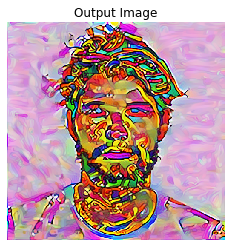

/home/jupyter/data/style_transfers_3/try-3-4-5-6
Optimizing...
SL:   634273 CL:   0
run [50]:
Style Loss : 2714.582520 Content Loss: 537.623413

SL:   2435 CL:   541
run [100]:
Style Loss : 735.799316 Content Loss: 548.243958

SL:   742 CL:   548
run [150]:
Style Loss : 483.919525 Content Loss: 548.226746

SL:   483 CL:   548
run [200]:
Style Loss : 596.130066 Content Loss: 553.198181

SL:   656 CL:   548
run [250]:
Style Loss : 360.275909 Content Loss: 549.509888

SL:   358 CL:   550
run [300]:
Style Loss : 347.900085 Content Loss: 547.776550

SL:   347 CL:   548
run [350]:
Style Loss : 659.038086 Content Loss: 558.606445

SL:   625 CL:   560
run [400]:
Style Loss : 351.474396 Content Loss: 558.421509

SL:   351 CL:   558
run [450]:
Style Loss : 3171.773193 Content Loss: 555.563538

SL:   2027 CL:   558
run [500]:
Style Loss : 319.182281 Content Loss: 551.826294

SL:   317 CL:   552
run [550]:
Style Loss : 3009.775146 Content Loss: 581.148438

SL:   2911 CL:   569
run [600]:
Style Los

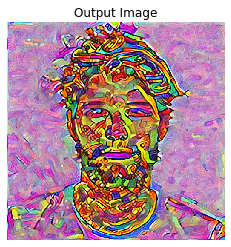

tensor([[[[0.5593, 0.5746, 0.4717,  ..., 0.8774, 0.8869, 0.9022],
          [0.5958, 0.5449, 0.5268,  ..., 0.8554, 0.8916, 0.9081],
          [0.5360, 0.5245, 0.5319,  ..., 0.8516, 0.8138, 0.8192],
          ...,
          [0.4610, 0.4712, 0.7449,  ..., 0.2724, 0.2965, 0.3366],
          [0.4335, 0.4978, 0.4878,  ..., 0.2656, 0.2495, 0.2303],
          [0.4235, 0.4509, 0.4959,  ..., 0.2852, 0.2754, 0.2451]],

         [[0.9802, 0.9895, 0.7793,  ..., 0.7042, 0.6951, 0.6729],
          [0.9770, 0.9242, 0.7684,  ..., 0.7417, 0.7371, 0.7145],
          [0.9681, 0.9697, 0.7861,  ..., 0.7050, 0.7228, 0.7007],
          ...,
          [0.2737, 0.2362, 0.4371,  ..., 0.5468, 0.5504, 0.5185],
          [0.2512, 0.2475, 0.3202,  ..., 0.6404, 0.6207, 0.5984],
          [0.2570, 0.2292, 0.2866,  ..., 0.6473, 0.6348, 0.6363]],

         [[0.6212, 0.6139, 0.6103,  ..., 0.7347, 0.7528, 0.7355],
          [0.6209, 0.5989, 0.6051,  ..., 0.7480, 0.7361, 0.7394],
          [0.5945, 0.6225, 0.6300,  ..., 0

In [48]:
hyperparam_traverse(batch_config)

In [49]:
from itertools import product, chain, combinations, permutations
from random import sample 
conv_layer_indices = list(range(0, 16))

In [50]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

layer_combos =  [list(subs) for subs in powerset(list(range(0, 16)) if subs != ()]

SyntaxError: invalid syntax (<ipython-input-50-d46a4a4ce4c8>, line 6)

In [ ]:

samp = sample(layer_combos,k=1000)
samp_layers = [
    [f'conv-{i}' for i in subsamp]
    for subsamp in samp]
samp_layers[:3]

In [ ]:
bc = batch_config.copy()
samp
bc["style_injects"] = samp_layers
hyperparam_traverse(bc, verbose=False)

/home/jupyter/data/style_transfers_2/try-1-6-8-11-13-14-15
Optimizing...
SL:   661456 CL:   0
SL:   4988 CL:   2251
SL:   1880 CL:   2181
SL:   1286 CL:   2118
SL:   4786 CL:   2094
SL:   782 CL:   2093
SL:   722 CL:   2057
SL:   23916 CL:   2758
SL:   2601 CL:   2422
SL:   1082 CL:   2370
SL:   888 CL:   2303
/home/jupyter/data/style_transfers_2/try-0-1-2-3-8-9-13-14
Optimizing...
SL:   660297 CL:   0
SL:   10069 CL:   2147
SL:   3093 CL:   2145
SL:   1609 CL:   2091
SL:   1304 CL:   2023
SL:   1310 CL:   1978
SL:   941 CL:   1982
SL:   818 CL:   1979
SL:   799 CL:   1960
SL:   96956 CL:   2337
SL:   3165 CL:   2306
/home/jupyter/data/style_transfers_2/try-1-4-7-8-10-11-12-14
Optimizing...
SL:   1976527 CL:   0
SL:   15696 CL:   2114
SL:   4432 CL:   2180
SL:   2228 CL:   2204
SL:   1573 CL:   2186
SL:   1726 CL:   2184
SL:   1174 CL:   2184
SL:   1034 CL:   2171
SL:   962 CL:   2169
SL:   1440054 CL:   1645
SL:   3579 CL:   2282
/home/jupyter/data/style_transfers_2/try-0-2-3-4-6-8-9-